# Assignment project on Machine learning (pose classification)

author: Nguyen Xuan Tung

---------------------------------------------------------------------------------------------------

### Library

In [2]:
!pip install torch
!pip install numpy
!pip install pandas
!pip install tensorflow
!pip install -U scikit-learn

In [3]:
import torch
#import cv2
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import seaborn as sns
import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import random

2023-09-01 18:50:37.759110: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-01 18:50:39.169219: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Data preprocessing

In [4]:
# Define classes based on folder names
class_names = [
    "action_down", "action_inside", "action_new", "action_outside",
    "action_remove_block", "action_select_block", "action_switch", "action_up",
    "block_events_ran", "category_control", "category_events", "category_looks",
    "category_motion", "category_sound", "dummy", "select_avatar", "select_backdrop"
]

# Create a dictionary to map class names to labels
class_to_label = {class_name: i for i, class_name in enumerate(class_names)}

folder_paths = [
    "actions/action_down", "actions/action_inside", "actions/action_new",
    "actions/action_outside", "actions/action_remove_block", "actions/action_select_block",
    "actions/action_switch", "actions/action_up", "actions/block_events_ran",
    "actions/category_control", "actions/category_events", "actions/category_looks",
    "actions/category_motion", "actions/category_sound", "actions/dummy",
    "actions/select_avatar", "actions/select_backdrop"
]

arrays = []
labels = []

for folder_path in folder_paths:
    action_class = os.path.basename(folder_path)
    label = class_to_label[action_class]
    file_names = os.listdir(folder_path)
    
    for file_name in file_names:
        if file_name.endswith('.npy'):
            file_path = os.path.join(folder_path, file_name)
            array = np.load(file_path)
            
            # Append the loaded array and its label
            arrays.append(array)
            labels.append(label)

# Convert lists to numpy arrays
data = np.array(arrays)
labels = np.array(labels)

print("Data shape:", data.shape)
print("Labels shape:", labels.shape)


Data shape: (40553, 1, 17, 64, 48)
Labels shape: (40553,)


In [5]:
data.shape

(40553, 1, 17, 64, 48)

In [6]:
array.shape

(1, 17, 64, 48)

In [7]:
def normalize_heatmap(array):
    # Get the minimum and maximum values across all keypoints and spatial dimensions
    min_value = array.min()
    max_value = array.max()
    
    # Normalize each value in the heatmap
    epsilon = 1e-10
    normalized_data = (array - min_value) / (max_value - min_value + epsilon)
    
    return normalized_data

In [8]:
normalized_data = normalize_heatmap(data)

In [9]:
normalized_data.shape

(40553, 1, 17, 64, 48)

### Model training 

In [10]:
X_train, X_temp, y_train, y_temp = train_test_split(
    normalized_data, labels, test_size=0.2, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42
)


print("Training data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)
print("Test data shape:", X_test.shape)

Training data shape: (32442, 1, 17, 64, 48)
Validation data shape: (6083, 1, 17, 64, 48)
Test data shape: (2028, 1, 17, 64, 48)


In [11]:
X_train = X_train.reshape(-1, 64, 48, 17)
X_val = X_val.reshape(-1, 64, 48, 17)
X_test = X_test.reshape(-1, 64, 48, 17)

In [12]:
X_train.shape

(32442, 64, 48, 17)

In [13]:
y_test.shape

(2028,)

In [14]:
os.chdir('model')

In [15]:
from cnn_model2 import cnn_model2


# Create the custom CNN model

input_shape = (64, 48, 17)
num_classes = 17
num_epochs = 5
y_train_one_hot = to_categorical(y_train, num_classes=num_classes)
y_val_one_hot = to_categorical(y_val, num_classes=num_classes)

# Create the custom CNN model
model = cnn_model2( num_classes,  input_shape)

# Compile and train the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train_one_hot, validation_data=(X_val, y_val_one_hot), epochs=num_epochs, batch_size= 1,
               verbose=2, shuffle=True)

# Evaluate the model on the test set
y_test_one_hot = to_categorical(y_test, num_classes=num_classes)
test_loss, test_accuracy = model.evaluate(X_test, y_test_one_hot)


print("Test loss:", test_loss)
print("Test accuracy:", test_accuracy)

Epoch 1/5


2023-09-01 18:53:50.838869: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 6777004032 exceeds 10% of free system memory.


32442/32442 - 657s - loss: 0.1738 - accuracy: 0.9480 - val_loss: 0.1121 - val_accuracy: 0.9668 - 657s/epoch - 20ms/step
Epoch 2/5
32442/32442 - 653s - loss: 0.0211 - accuracy: 0.9946 - val_loss: 0.0830 - val_accuracy: 0.9785 - 653s/epoch - 20ms/step
Epoch 3/5
32442/32442 - 650s - loss: 0.0140 - accuracy: 0.9967 - val_loss: 0.1610 - val_accuracy: 0.9647 - 650s/epoch - 20ms/step
Epoch 4/5
32442/32442 - 648s - loss: 0.0103 - accuracy: 0.9974 - val_loss: 0.0817 - val_accuracy: 0.9770 - 648s/epoch - 20ms/step
Epoch 5/5
32442/32442 - 649s - loss: 0.0078 - accuracy: 0.9984 - val_loss: 0.0330 - val_accuracy: 0.9906 - 649s/epoch - 20ms/step
64/64 [==============================] - 4s 50ms/step - loss: 0.0449 - accuracy: 0.9911
Test loss: 0.04491199925541878
Test accuracy: 0.9911242723464966


In [16]:
# Predict output
predictions = model.predict(X_test)

64/64 [==============================] - 3s 49ms/step


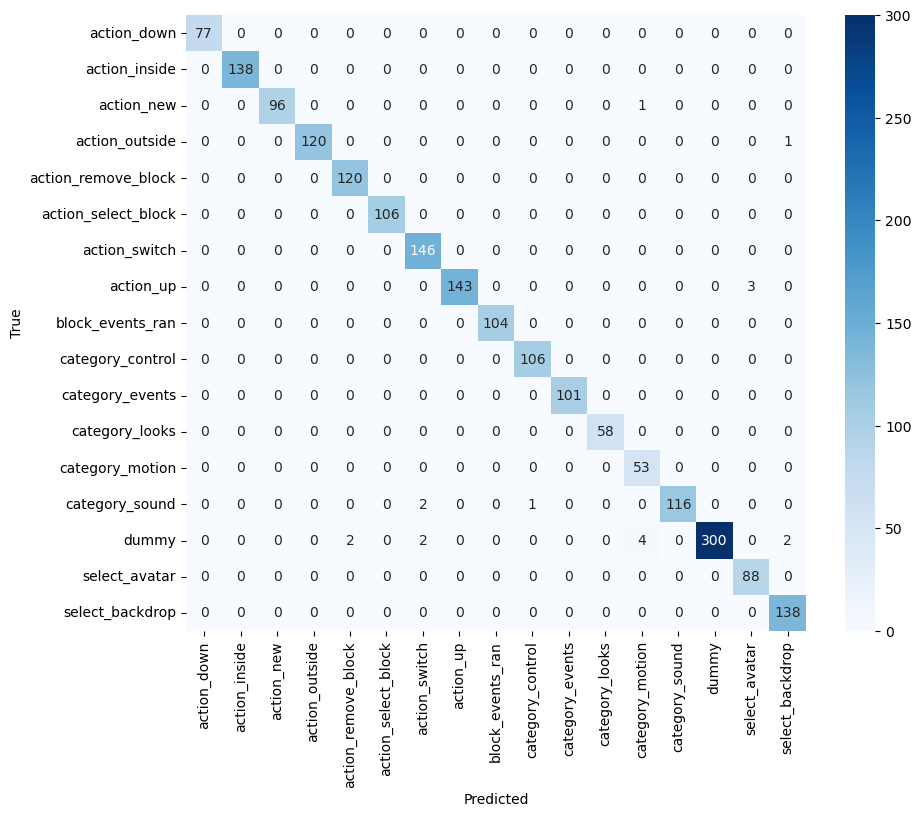

In [17]:
y_pred_labels = np.argmax(predictions, axis=1)
confusion = confusion_matrix(y_test, y_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [18]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 48, 17)]         0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 24, 32)           4928      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 32, 24, 32)           128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 re_lu (ReLU)                (None, 32, 24, 32)           0         ['batch_normalization[0][0

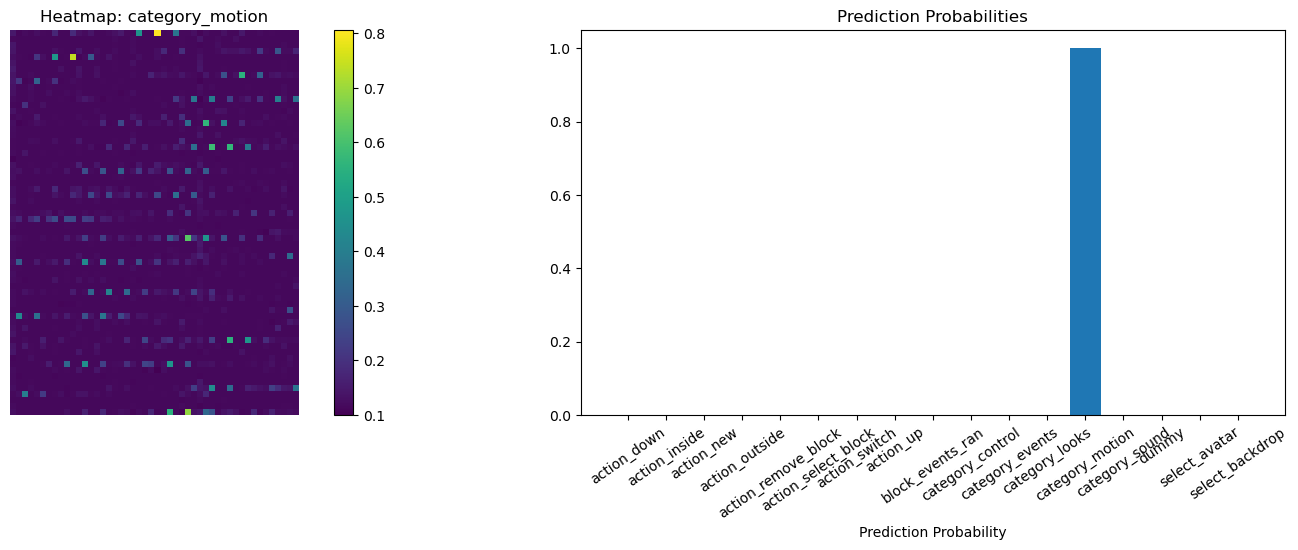

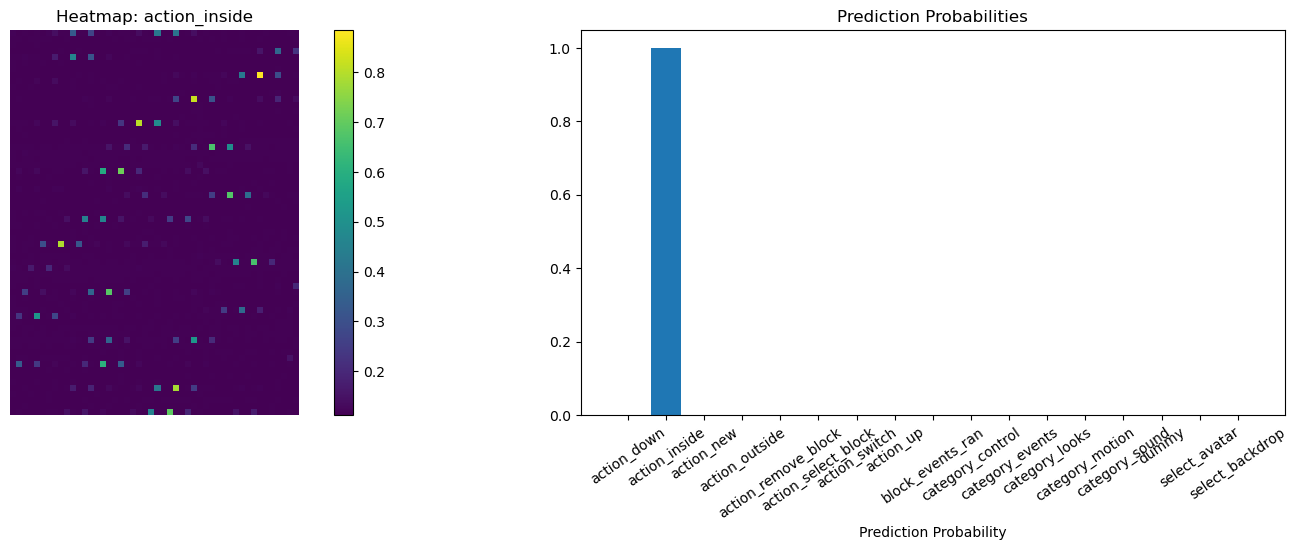

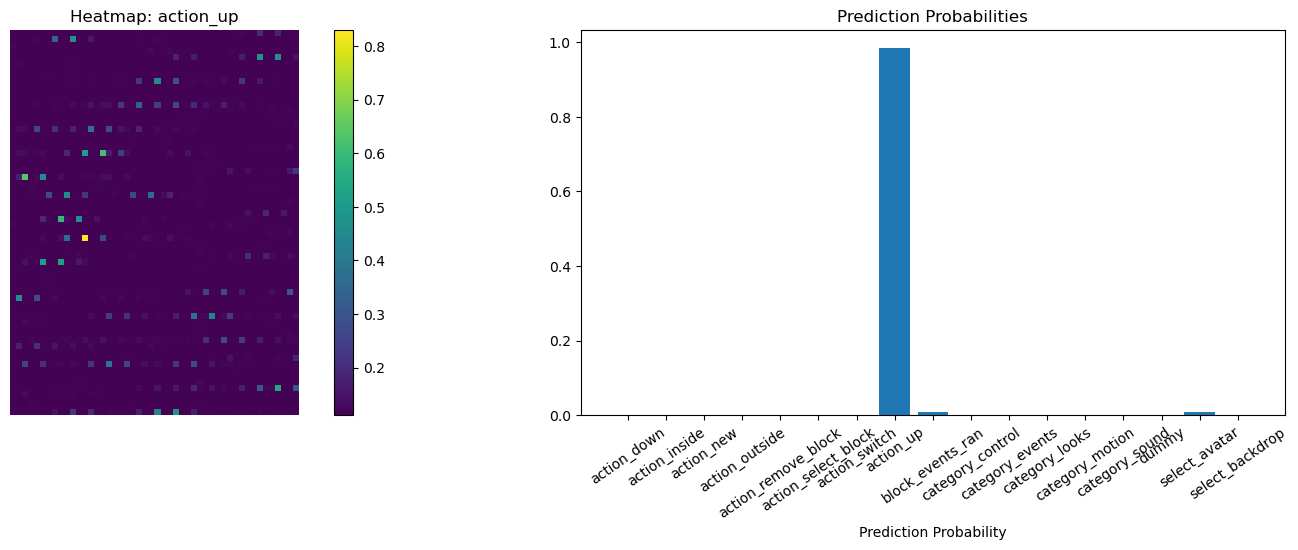

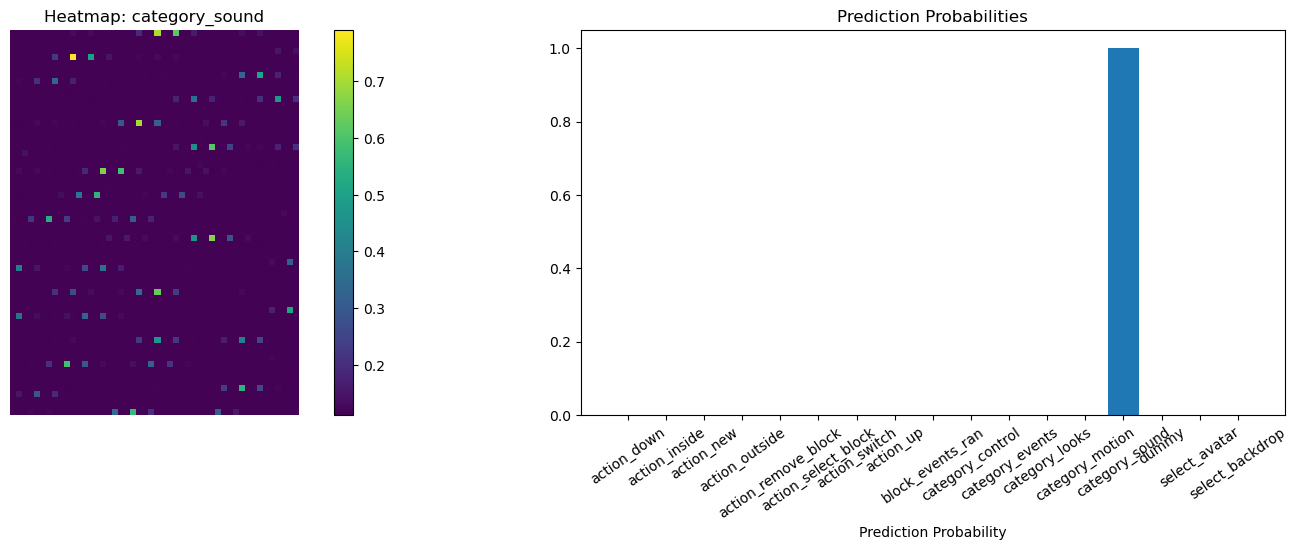

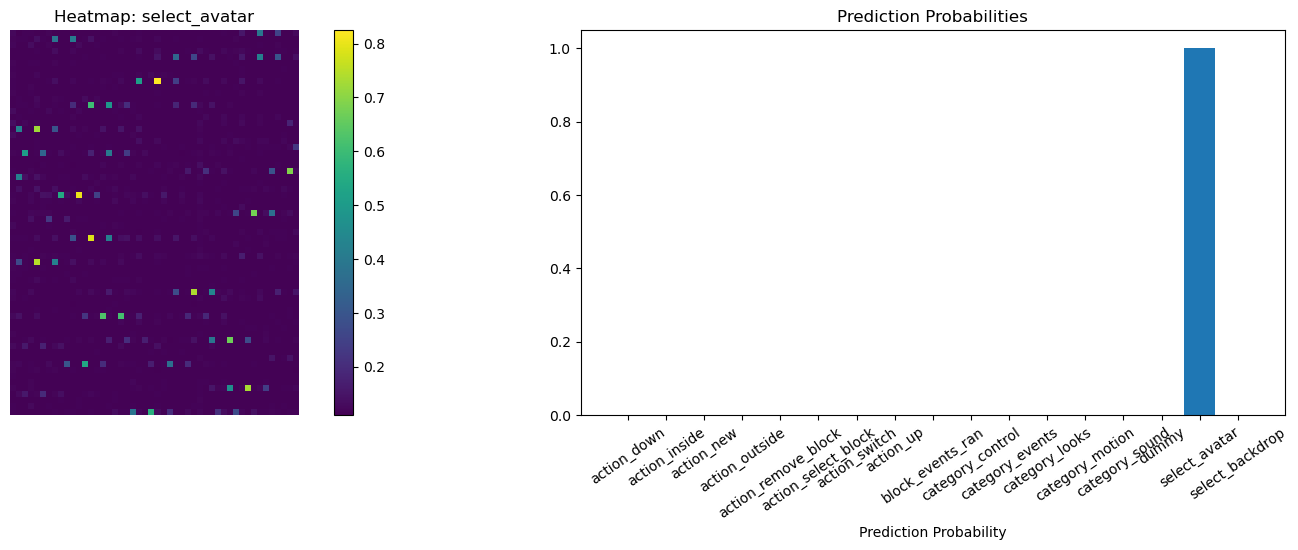

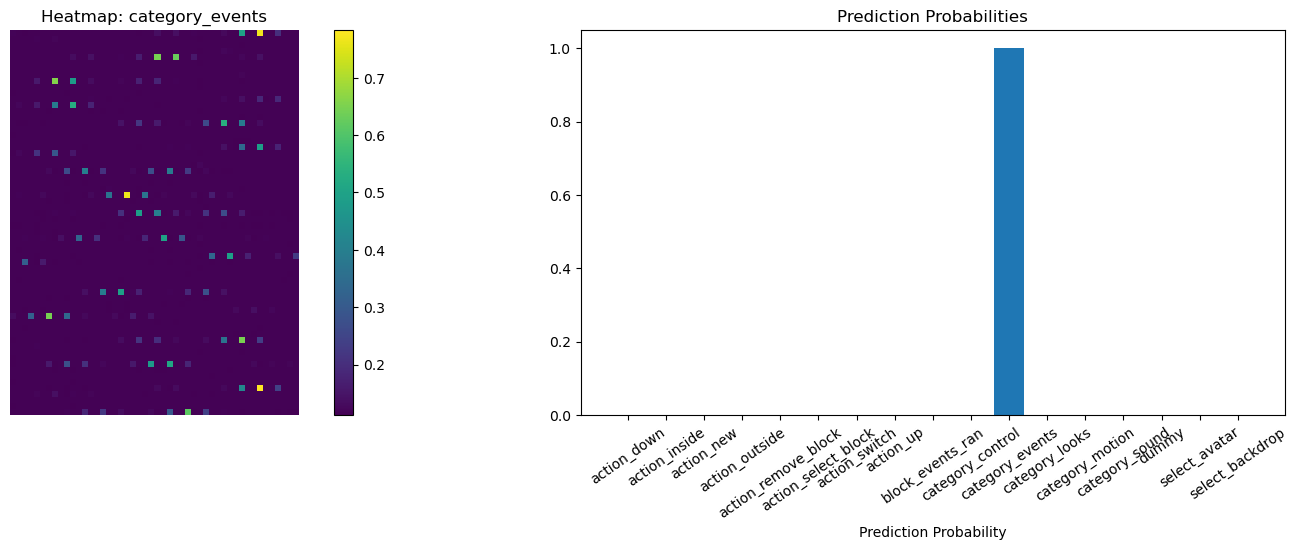

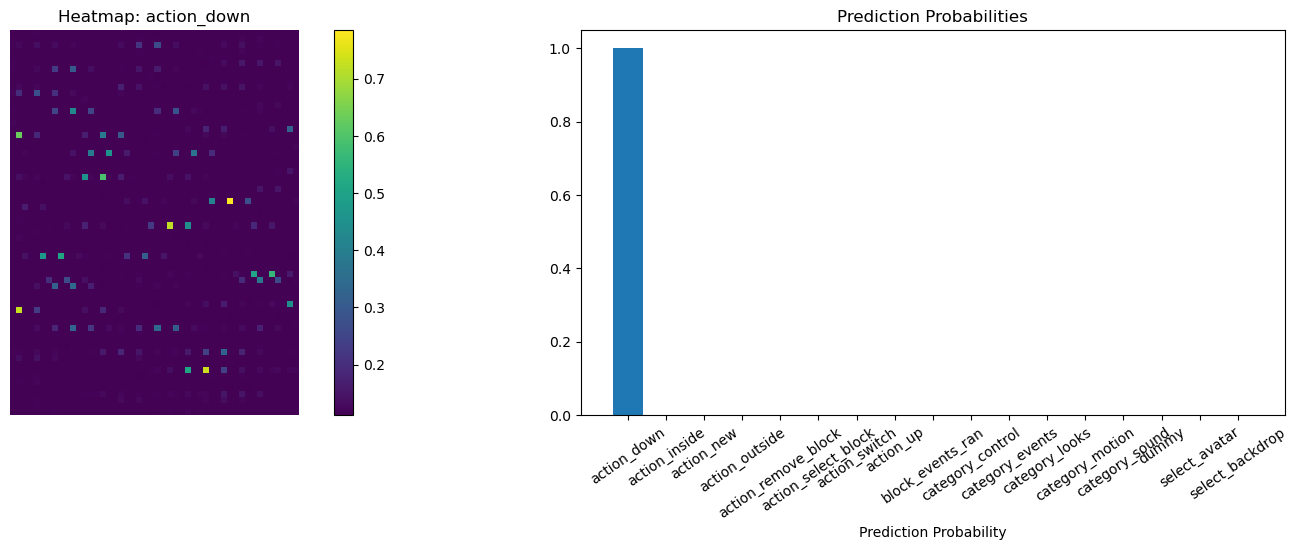

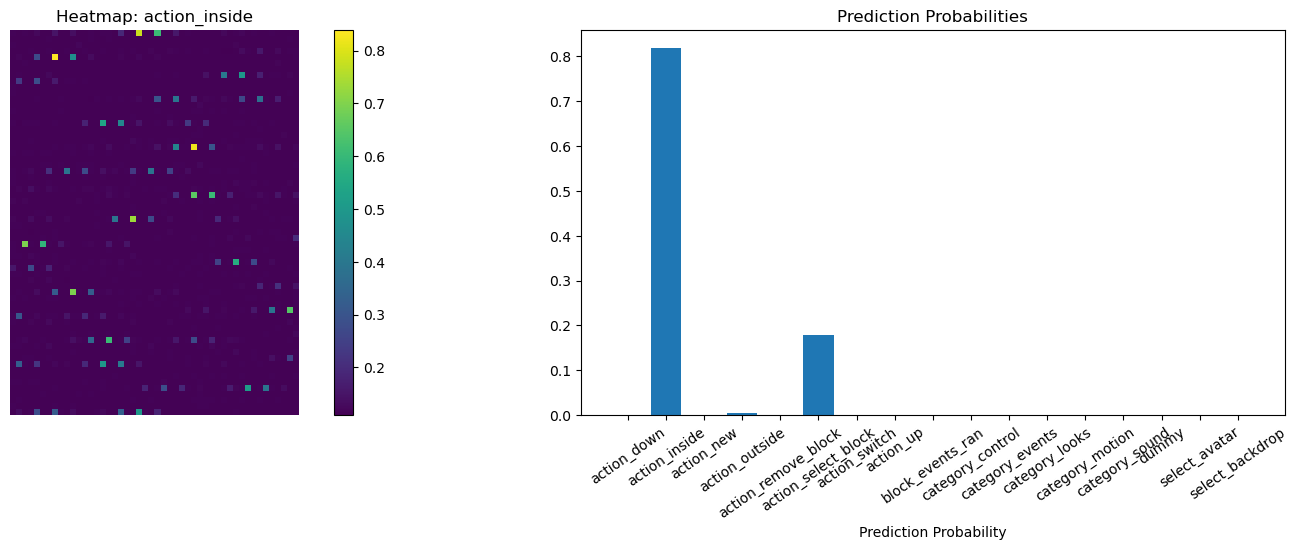

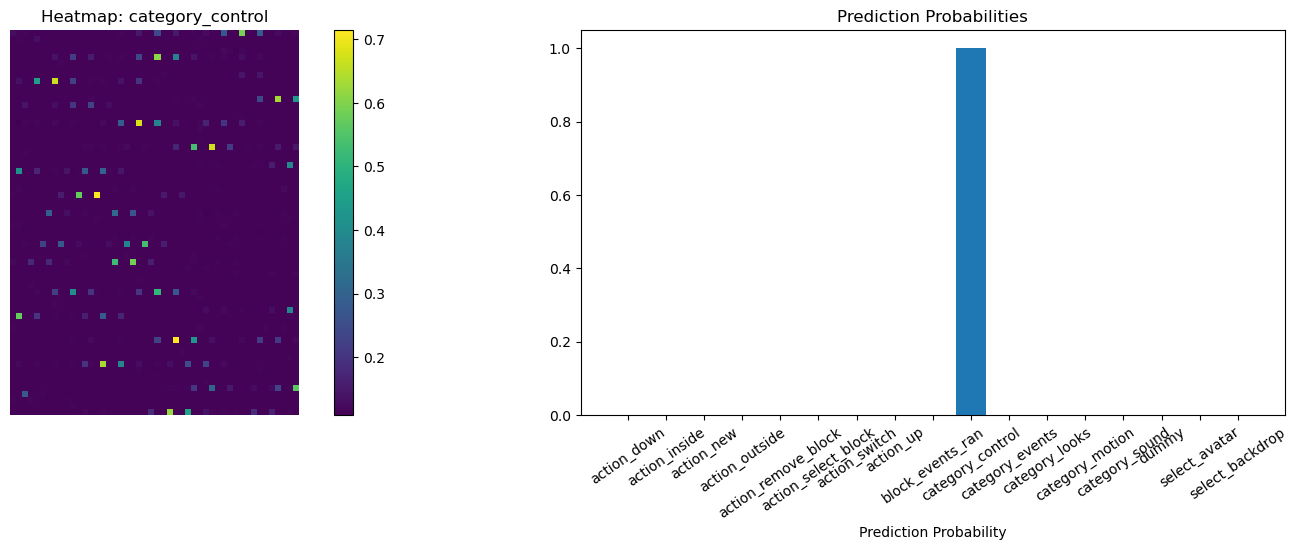

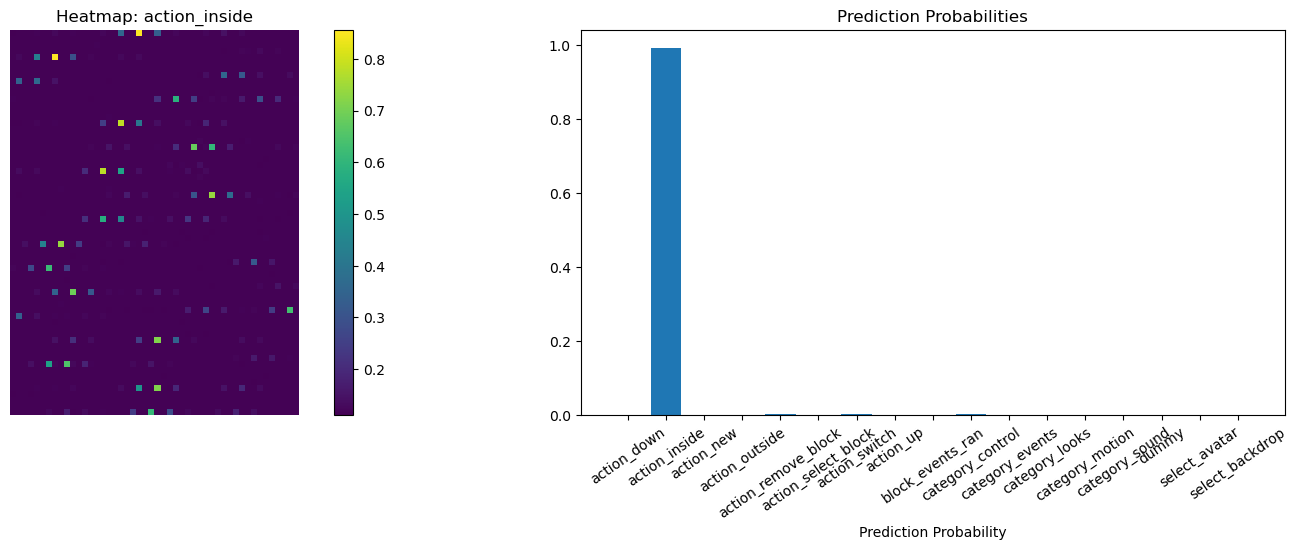

In [19]:
num_examples_to_visualize = 10 
random_indices = random.sample(range(len(X_test)), num_examples_to_visualize)

for i in random_indices:
    example_index = i  # Choose the example index
    heatmap = X_test[example_index, :, :, 0]  # Using the first heatmap in the sequence
    prediction = predictions[example_index]
    true_label = y_test[example_index]
    
    plt.figure(figsize=(20, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(heatmap)
    plt.title(f"Heatmap: {class_names[true_label]}")
    plt.colorbar()
    plt.axis("off")
    
    
    plt.subplot(1, 2, 2)
    plt.bar(class_names, prediction[0:17])
    plt.xlabel("Prediction Probability")
    plt.xticks(rotation=35)
    plt.title("Prediction Probabilities")


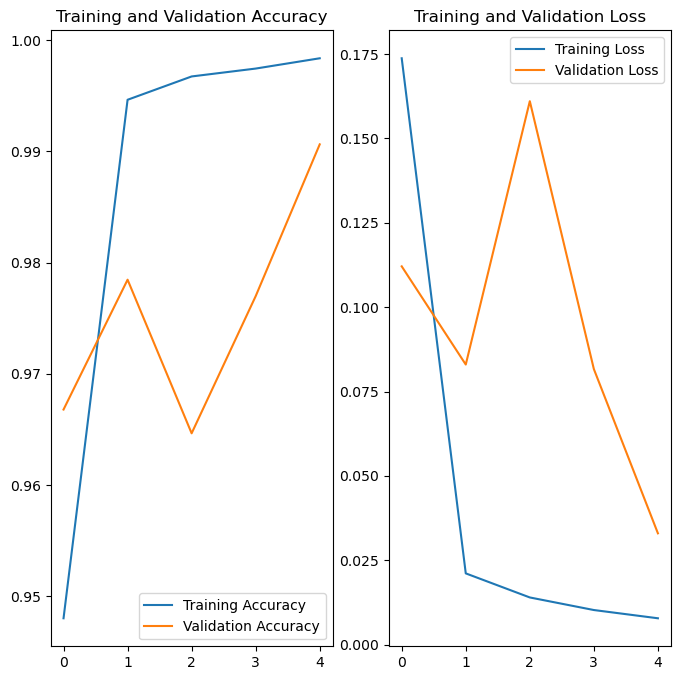

In [20]:
# Extract accuracy and validation accuracy values from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Extract loss and validation loss values from the history object
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

# Plot the accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot the loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

### Deploy trained model and read new dataset

In [21]:
folder_path = "trained_model2"
# Save the model's architecture and weights
model.save(os.path.join(folder_path, "cnn_model2_architecture.h5"))
model.save_weights(os.path.join(folder_path, "cnn_model2_weights.h5"))


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
